##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Virtual Try-On with Gemini 2.0 & Imagen 3
This notebook is an implementation of virtually trying on different outfits by image editing and inpainting using Imagen 3, along with Gemini 2.0 for zero-shot object detection and SAM-2 for creating segmentation masks.

#### Developed by [Nitin Tiwari](https://linkedin.com/in/tiwari-nitin).

----
<a target="_blank" href="https://colab.research.google.com/github/NSTiwari/Virtual-Try-On-Imagen3/blob/main/Virtual_Try_On_Imagen3.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### **Pipeline:**

![Description of Image](https://raw.githubusercontent.com/NSTiwari/Virtual-Try-On-Imagen3/main/assets/Imagen3_Pipeline.png)

## Step 1: Install Gen AI SDK

In [1]:
!pip install -U -q "google-genai>=1.0.0"
!pip install jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.7/137.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.9 MB/s eta 0:00:00


## Step 2: Install SAM-2
In our pipeline, we'll use SAM-2 to create segmentation masks that will be fed as an input to Imagen 3, along with the original image for editing and inpainting.

*Note: You might need to restart the runtime after the execution of below cell.*

In [2]:
!git clone https://github.com/facebookresearch/segment-anything-2
%cd /content/segment-anything-2
!pip install -e .

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 12.06 MiB/s, done.
Resolving deltas: 100% (375/375), done.
/content/segment-anything-2
Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cac

## Step 3: Download SAM 2.1 Checkpoints
We'll be using the latest SAM 2.1 checkpoints, as they offer improved performance and output compared to previous versions. SAM 2.1 is available in the following versions:

* Tiny
* Small
* Base+
* Large

For images with complex segments, the Large version is typically recommended. However, for our use case, the SAM 2.1 Small version will be sufficient.

In [1]:
!mkdir -p /content/sam2.1_checkpoints
!wget -q sam2_hiera_tiny.pt https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt -P /content/sam2.1_checkpoints
!wget -q sam2_hiera_small.pt https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt -P /content/sam2.1_checkpoints
!wget -q sam2_hiera_base_plus.pt https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt -P /content/sam2.1_checkpoints
!wget -q sam2_hiera_large.pt https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt -P /content/sam2.1_checkpoints

## Step 4: Import libraries

In [79]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from google.colab import output
output.enable_custom_widget_manager()
from jupyter_bbox_widget import BBoxWidget

from google.colab import auth
auth.authenticate_user()

from PIL import Image as PILImage
from google.colab import userdata
from matplotlib import pyplot as plt
from google import genai
from google.genai import types
import torch
import base64
import cv2
import re
import json
import torchvision
import numpy as np
import vertexai
from vertexai.preview.vision_models import (
    ControlReferenceImage,
    Image,
    ImageGenerationModel,
    MaskReferenceImage,
    RawReferenceImage,
)

## Step 5: Configure Gemini API key and GCP Project ID

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [80]:
# Comfigure Gemini API key.
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GEMINI_API_KEY)

# Configure GCP Project ID for Vertex AI.
GCP_PROJECT_ID = userdata.get('GCP_PROJECT_ID')

# Configure model.
MODEL_ID = "gemini-2.0-flash" # @param ["gemini-1.5-flash-latest","gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.0-pro-exp-02-05"] {"allow-input":true}

#### System Instructions

In [81]:
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
      """

In [82]:
safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

In [84]:
# @title Utility functions: Parse response and draw bounding boxes

def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output


def draw_bounding_boxes(image, response):
    label_colors = {}  # For label coloring
    if image.mode != 'RGB':
        image = image.convert('RGB')

    image = np.array(image)
    height, width, _ = image.shape  # Get the height and width of the image

    # Parse the JSON response directly
    json_output = parse_json(response)

    # Load the parsed JSON data
    bounding_boxes = json.loads(json_output)

    for box in bounding_boxes:
        bounding_box = box["box_2d"]  # Get the coordinates
        label = box["label"]  # Get the label

        # Extract bounding box coordinates from model output (normalized to [0, 1000])
        ymin, xmin, ymax, xmax = bounding_box

        # Convert the normalized coordinates to actual pixel values based on image size
        abs_y1 = int(ymin / 1000 * height)
        abs_x1 = int(xmin / 1000 * width)
        abs_y2 = int(ymax / 1000 * height)
        abs_x2 = int(xmax / 1000 * width)

        # Ensure the bounding box is in the correct order (xmin < xmax and ymin < ymax)
        if abs_x1 > abs_x2:
            abs_x1, abs_x2 = abs_x2, abs_x1

        if abs_y1 > abs_y2:
            abs_y1, abs_y2 = abs_y2, abs_y1

        # Store coordinates for potential further use
        coordinates = [abs_x1, abs_y1, abs_x2, abs_y2]

        # Assign a random color to the label (or reuse the same color if already assigned)
        if label not in label_colors:
            color = tuple(np.random.randint(0, 256, 3))  # Generate random BGR color
            # Ensure color is in the form (B, G, R)
            color = (int(color[0]), int(color[1]), int(color[2]))
            label_colors[label] = color
        else:
            color = label_colors[label]

        # Font settings for the label
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_thickness = 2
        box_thickness = 2
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

        # Label text background position (to make the text readable)
        text_bg_x1 = abs_x1
        text_bg_y1 = abs_y1 - text_size[1] - 5
        text_bg_x2 = abs_x1 + text_size[0] + 8
        text_bg_y2 = abs_y1

        # Draw background for label and the label text itself
        cv2.rectangle(image, (text_bg_x1, text_bg_y1), (text_bg_x2, text_bg_y2), color, -1)
        cv2.putText(image, label, (abs_x1 + 2, abs_y1 - 5), font, font_scale, (255, 255, 255), font_thickness)

        # Draw the bounding box itself
        cv2.rectangle(image, (abs_x1, abs_y1), (abs_x2, abs_y2), color, box_thickness)

    image = PILImage.fromarray(image)
    return image, coordinates

## Step 6: Zero-shot Object Detection by Gemini 2.0

Pass the image, and the object to be detected as part of the text prompt to Gemini 2.0.

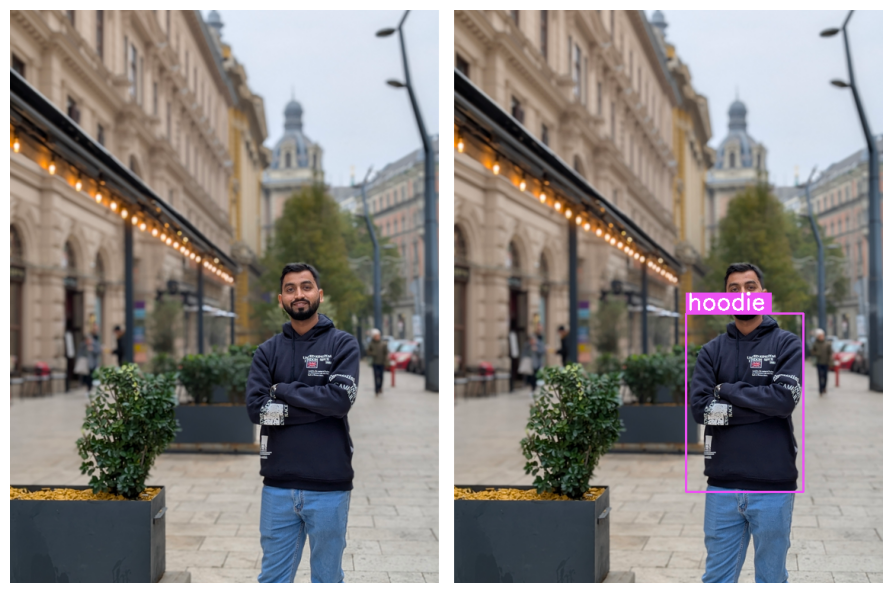

In [90]:
input_image = 'image_01.png' # @param {type : 'string'}
object_to_detect = 'hoodie' # @param {type: 'string'}
img = PILImage.open(input_image)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
    img,
    (
        f"Detect 2d bounding box of {object_to_detect}"
    )],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

result = response.text
result = result.replace("```", "")
result = result.replace("json", "")

bounding_box = parse_json(result)
output, coordinates = draw_bounding_boxes(img, bounding_box)
output_image = f'detect_{input_image}'
output.save(output_image)

img_array = np.array(img)
output_array = np.array(output)

gap_width = 20
empty_img = np.full((img_array.shape[0], gap_width, img_array.shape[2]), 255, dtype=img_array.dtype)
combined_image = np.hstack((img_array, empty_img, output_array))

fig, axes = plt.subplots(1, 1, figsize=(img_array.shape[1] / 50, img_array.shape[0] / 50))

axes.imshow(combined_image)
axes.axis('off')

plt.show()

## Step 7: Draw points within ROI

Now that we have the portion of the image that needs to be segmented, we can either automatically draw the points using the bounding box generated by Gemini 2.0 or manually annotate them.

The more precise the mask, the better the resulting output will be when processed by Imagen 3.

In [91]:
annotation = 'Automatic' # @param ['Automatic', 'Manual']

In [136]:
captured_points = []

def encode_image(filepath):
  with open(filepath, 'rb') as f:
    image_bytes = f.read()
  encoded = str(base64.b64encode(image_bytes), 'utf-8')
  return "data:image/jpg;base64,"+encoded

def handle_captured_points(points):
    global captured_points
    captured_points = points

def get_roi_points(input_image, annotation):
  global captured_points
  if annotation == 'Automatic':
    image = cv2.imread(input_image)
    x1, y1, x2, y2 = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    centre_x = (x1+x2)//2
    centre_y = (y1+y2)//2

    color = (0, 255, 0)
    radius = 5

    # Draw the points on the image.
    p1 = (centre_x, centre_y)
    p2 = (centre_x, (centre_y+y1)//2)
    p3 = (centre_x, (centre_y+y2)//2)
    p4 = ((centre_x+x1)//2, centre_y)
    p5 = ((centre_x+x2)//2, centre_y)

    points = [p1, p2, p3, p4, p5]

    cv2.circle(image, p1, radius, color, -1)
    cv2.circle(image, p2, radius, color, -1)
    cv2.circle(image, p3, radius, color, -1)
    cv2.circle(image, p4, radius, color, -1)
    cv2.circle(image, p5, radius, color, -1)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    roi_output = PILImage.fromarray(image)
    roi_output.save(f'roi_point_{input_image}')
    display(roi_output)
    return points
  else:
    widget = BBoxWidget(classes=[object_to_detect])
    widget.image = encode_image(input_image)
    display(widget)
    callback=handle_captured_points
    def on_submit():
            bboxes = widget.bboxes
            if bboxes:
                points = [(box['x'], box['y']) for box in bboxes]
                if callback:
                    callback(points)
            else:
                print("No bounding boxes selected.")

    widget.on_submit(on_submit)
    points = captured_points
    return points

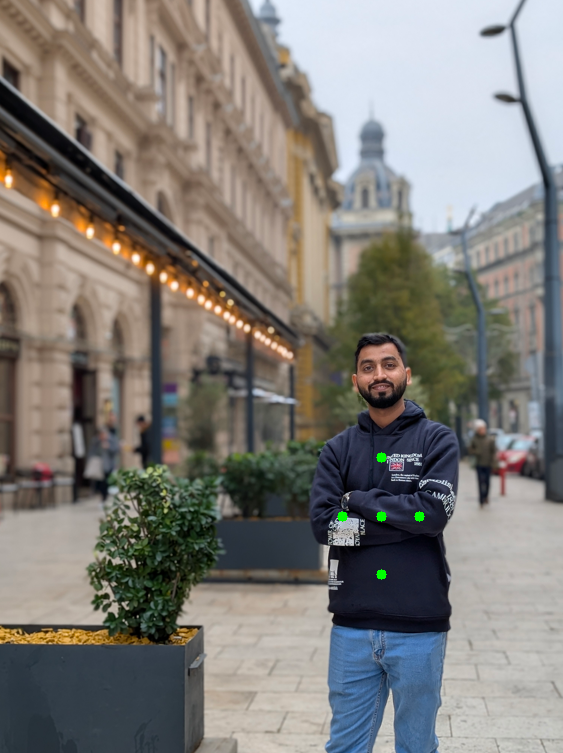

In [137]:
points = get_roi_points(input_image, annotation=annotation)

In [138]:
if annotation == 'Manual':
  points = captured_points

#### Step 8: Get segmentation mask from SAM 2.1

First, we load the SAM 2.1 model checkpoints. For our task, SAM 2.1 Small will be sufficient.

In [119]:
sam2_checkpoint = "sam2.1_hiera_small.pt"  # @param ["sam2.1_hiera_tiny.pt", "sam2.1_hiera_small.pt", "sam2.1_hiera_base_plus.pt", "sam2.1_hiera_large.pt"]
model_config = "sam2.1_hiera_s.yaml" # @param ["sam2.1_hiera_t.yaml", "sam2.1_hiera_s.yaml", "sam2.1_hiera_b+.yaml", "sam2.1_hiera_l.yaml"]

sam2_checkpoint = f"/content/sam2.1_checkpoints/{sam2_checkpoint}"

model_config = f"configs/sam2.1/{model_config}"

sam2_model = build_sam2(model_config, sam2_checkpoint, device="cuda")
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)
predictor = SAM2ImagePredictor(sam2_model)


Since SAM 2.1 doesn't directly support text prompts as input, we'll provide the key points generated in Step 7 as input to SAM 2.1 to predict the segmentation mask.

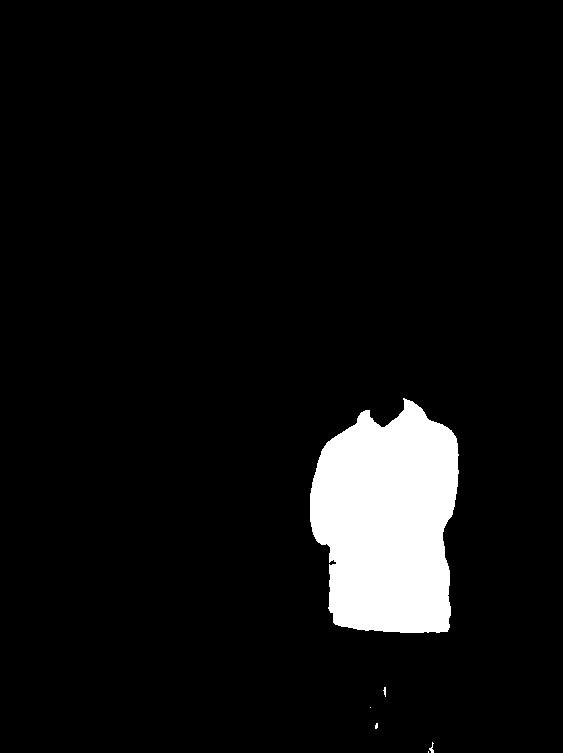

In [125]:
input_point = np.array([
      [
        point[0],
        point[1]
      ] for point in points
  ])

input_label = np.ones(input_point.shape[0])

predictor.set_image(img)

masks, scores, logits = predictor.predict(
    point_coords = input_point,
    point_labels = input_label,
    multimask_output = False,
)

mask_img = PILImage.fromarray((masks[0]*255).astype(np.uint8))
mask_img.save(f"{annotation}_mask_{input_image}")
display(mask_img)

## Step 9: Configure Imagen 3 parameters

Now, we need to configure certain parameters as follows:

* `Base image`: The input image file to be edited.
* `Mask file:`: The binary mask of the object to be inpainted.
* `Edit mode`: Options like inpainting-insert, inpainting-remove, or outpainting.
* `Mask mode`: Background or foreground
* `Dilation`: A float value between 0 and 1 indicating the percentage of the provided mask.

In [131]:
mask_file = f"{annotation}_mask_{input_image}"
output_file = f"output_{input_image}"
prompt = "A dark green jacket, white shirt inside it" # @param {type: 'string'}

edit_mode = 'inpainting-insert' # @param ['inpainting-insert', 'outpainting', 'inpainting-remove']
mask_mode = 'foreground' # @param ['foreground', 'background']
dilation = 0.01 # @param {type:"slider", min:0, max:1, step:0.01}

## Step 10: Generate and inpaint new image using Imagen 3

We're finally ready to generate and edit the image using Imagen 3.

*Note: For accurate image generation and editing, make sure you have a precise mask of the object. Also, craft a detailed prompt to enhance detection and results. Achieving optimal results may require several attempts.*

In [133]:
vertexai.init(project=GCP_PROJECT_ID, location="us-central1")

edit_model = ImageGenerationModel.from_pretrained("imagen-3.0-capability-001")

base_img = Image.load_from_file(location=input_image)
mask_img = Image.load_from_file(location=mask_file)

raw_ref_image = RawReferenceImage(image=base_img, reference_id=0)
mask_ref_image = MaskReferenceImage(
    reference_id=1, image=mask_img, mask_mode=mask_mode, dilation=dilation
)

edited_image = edit_model.edit_image(
    prompt=prompt,
    edit_mode=edit_mode,
    reference_images=[raw_ref_image, mask_ref_image],
    number_of_images=1,
    safety_filter_level="block_some",
    person_generation="allow_adult",
)

edited_image[0].save(output_file)

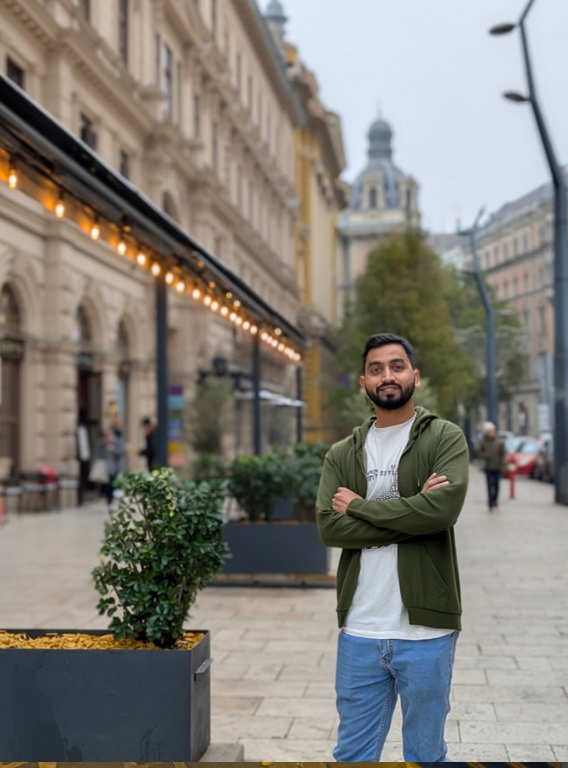

In [135]:
output_file = PILImage.open('output_image_01.png')
display(output_file)

Congratulations on successfully completing this tutorial and building your own Virtual Try-On application using Gemini 2.0's advanced object detection and Imagen 3's powerful image generation capabilities.